# **Generazione di dataset sintetici con diversi livelli di privacy: no privacy, privacy moderata e privacy strong**

Determinareil trade-off tra livello di privacy e l'effettiva utilità del dataset sintetico

In [ ]:
#SALVA TUTTE LE CARTELLE E FILE
!zip -r all_colab_files.zip /content

from google.colab import files
files.download("all_colab_files.zip")

In [2]:
# 1. Install Torch compatibile con Python 3.12
!pip install --quiet torch==2.3.1+cpu torchvision==0.18.1+cpu torchaudio==2.3.1+cpu --index-url https://download.pytorch.org/whl/cpu

# 2. Install SDV recente
!pip install --quiet sdv==1.29.1

# 3. Install CTGAN
!pip install --quiet ctgan==0.11.1

# 4. Install smartnoise
!pip install smartnoise-synth==1.0.5

# 5. Install diffprivlib
!pip install diffprivlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.4/190.4 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.0/197.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.3/1

In [3]:
import os
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

from sdv.evaluation.single_table import run_diagnostic
from sdv.evaluation.single_table import evaluate_quality

from diffprivlib.mechanisms import Laplace
from sdv.evaluation.single_table import evaluate_quality, run_diagnostic, get_column_plot

from xgboost import XGBClassifier
import joblib
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

import warnings
warnings.filterwarnings('ignore')

## **CARICAMENTO DEL DATASET E SUDDIVISIONE IN TRAIN E HOLDOUT**

In [4]:
def carica_dataset():

    path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")
    print("Path to dataset files:", path)

    url = os.path.join(path, "diabetes.csv")
    df = pd.read_csv(url)

    df.columns = ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness',
                  'insulin', 'bmi', 'diabetes_pedigree', 'age', 'outcome']
    print("Dataset caricato")
    return df

def preprocessa_dataset(df):
    # Le colonne dove 0 è probabile indicatore di dato mancante
    cols_missing = ['glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi']

    # Sostituisci 0 con NaN in queste colonne specifiche
    df[cols_missing] = df[cols_missing].replace(0, np.nan)

    # Riempimento NaN con mediana colonna
    df[cols_missing] = df[cols_missing].fillna(df[cols_missing].median())

    # Controllo completo e eventuale ulteriore riempimento per NaN residui in tutto il dataframe
    df = df.fillna(df.median())

    #trasforma in int quelle che sono float con nessun decimale davvero
    cols_to_int = ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'age', 'outcome']
    for col in cols_to_int:
        if col in df.columns:
            df[col] = df[col].astype(float)
            df[col] = np.rint(df[col]).astype('int64', errors='ignore')

    return df

# Crea le directory se non esistono
os.makedirs("dataset/real", exist_ok=True)
os.makedirs("dataset/synthetic", exist_ok=True)
os.makedirs("models", exist_ok=True)

df = carica_dataset()
df = preprocessa_dataset(df)
df.info()

# Suddivide il dataset in train e holdout
train_df, holdout_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['outcome'])

# Salva i due dataset in CSV separati
train_df.to_csv('dataset/real/diabetes_train.csv', index=False)
holdout_df.to_csv('dataset/real/diabetes_holdout.csv', index=False)

print(f"Dimensione train: {train_df.shape}")
print(f"Dimensione holdout: {holdout_df.shape}")

Using Colab cache for faster access to the 'pima-indians-diabetes-database' dataset.
Path to dataset files: /kaggle/input/pima-indians-diabetes-database
Dataset caricato
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pregnancies        768 non-null    int64  
 1   glucose            768 non-null    int64  
 2   blood_pressure     768 non-null    int64  
 3   skin_thickness     768 non-null    int64  
 4   insulin            768 non-null    int64  
 5   bmi                768 non-null    float64
 6   diabetes_pedigree  768 non-null    float64
 7   age                768 non-null    int64  
 8   outcome            768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
Dimensione train: (614, 9)
Dimensione holdout: (154, 9)


## **GENERAZIONE DATI SINTETICI**

### NO PRIVACY

In [109]:
def synthetic_no_privacy(df):
    # Metadata
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df)
    metadata.update_column('outcome', sdtype='categorical')
    metadata.update_column('pregnancies', sdtype='numerical')

    # Modello CTGAN
    model = CTGANSynthesizer(
        metadata,
        epochs=300,
        batch_size=32,
        generator_dim=(64, 64, 64),
        discriminator_dim=(64, 64, 64),
        verbose=True,
        pac=1
    )
    model.fit(df)

    # Genera dati sintetici
    synthetic= model.sample(5000) #num_rows=len(df)

    model.save("models/ctgan_no_privacy.pkl")

    return synthetic, metadata

synthetic_noprivacy, metadata_noprivacy = synthetic_no_privacy(train_df)
synthetic_noprivacy.to_csv('dataset/synthetic/synthetic_no_privacy.csv', index=False)
synthetic_noprivacy.info()

Gen. (-1.00) | Discrim. (-0.09): 100%|██████████| 300/300 [01:29<00:00,  3.34it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pregnancies        5000 non-null   int64  
 1   glucose            5000 non-null   int64  
 2   blood_pressure     5000 non-null   int64  
 3   skin_thickness     5000 non-null   int64  
 4   insulin            5000 non-null   int64  
 5   bmi                5000 non-null   float64
 6   diabetes_pedigree  5000 non-null   float64
 7   age                5000 non-null   int64  
 8   outcome            5000 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 351.7 KB


### CON PRIVACY

In [ ]:
def synthetic_privacy(df, epsilon, model_path):
    print(f"\nGENERAZIONE DATASET SINTETICO ε={epsilon:.2f}")

    # 1. NO rumore iniziale (puro reale)
    df_work = df.copy()

    # 2. Statistiche DP
    print("Statistiche DP")
    stats = {}
    epsilon_per_stat = epsilon / 16  # Composizione: 8 mean + 8 std

    for col in df_work.select_dtypes(include=[np.number]).columns:
        if col == 'outcome': continue

        col_data = df_work[col].astype(float)
        lower, upper = col_data.min(), col_data.max()

        # NO forcing std → utility degrada naturalmente
        true_std = col_data.std()
        true_mean = col_data.mean()

        # Sensitivity pure
        sens_std = upper - lower
        sens_mean = (upper - lower) / len(df)

        # Laplace con budget diviso
        mech_std = Laplace(epsilon=epsilon_per_stat, sensitivity=sens_std)
        mech_mean = Laplace(epsilon=epsilon_per_stat, sensitivity=sens_mean)

        dp_std = mech_std.randomise(true_std)
        dp_mean = mech_mean.randomise(true_mean)

        stats[col] = {'mean': dp_mean, 'std': dp_std, 'range': (lower, upper)}
        print(f"  {col}: μ={dp_mean:.2f}±{sens_mean:.3f}, σ={dp_std:.2f}±{sens_std:.1f}")

    # 3. Normalizzazione
    df_norm = df_work.copy()
    for col, stat in stats.items():
        df_norm[col] = (df_norm[col] - stat['mean']) / stat['std']

    # Cleanup MINIMO (solo NaN, NO inf→0)
    df_norm = df_norm.fillna(df_norm.median())

    # 4. CTGAN
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df_norm)
    metadata.update_column('outcome', sdtype='categorical')

    model = CTGANSynthesizer(
        metadata,
        epochs=500,
        batch_size=40,
        verbose=True
    )

    model.fit(df_norm)
    synthetic_norm = model.sample(5000) #len(df)

    # 5. Denormalizza + clipping MINIMO
    synthetic = synthetic_norm.copy()
    for col, stat in stats.items():
        synthetic[col] = np.clip(
            synthetic[col] * stat['std'] + stat['mean'],
            stat['range'][0] * 0.9,
            stat['range'][1] * 1.1
        )

    # 6. Tipi corretti
    #int_cols = ['pregnancies', 'age', 'outcome']
    int_cols = ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'age', 'outcome']
    for col in int_cols:
        synthetic[col] = np.rint(synthetic[col]).astype(int)

    model.save(model_path)

    return synthetic, metadata

**PRIVACY MODERATA**

In [127]:
# PRIVACY MODERATA
synthetic_mod, metadata_mod = synthetic_privacy(train_df, epsilon=5.0, model_path="models/ctgan_privacy_moderata.pkl")
synthetic_mod.to_csv("dataset/synthetic/synthetic_privacy_moderata.csv", index=False)


GENERAZIONE DATASET SINTETICO ε=5.00
Statistiche DP
  pregnancies: μ=3.94±0.028, σ=16.21±17.0
  glucose: μ=121.62±0.233, σ=-584.38±143.0
  blood_pressure: μ=72.21±0.160, σ=85.30±98.0
  skin_thickness: μ=30.02±0.150, σ=188.43±92.0
  insulin: μ=136.51±1.187, σ=-3556.52±729.0
  bmi: μ=32.46±0.080, σ=-17.21±48.9
  diabetes_pedigree: μ=0.47±0.004, σ=-4.88±2.2
  age: μ=32.88±0.098, σ=-228.86±60.0


Gen. (-1.45) | Discrim. (0.71): 100%|██████████| 500/500 [03:29<00:00,  2.39it/s]


**PRIVACY STRONG**

In [ ]:
# PRIVACY STRONG
synthetic_strong, metadata_strong = synthetic_privacy(train_df, epsilon=0.2, model_path="models/ctgan_privacy_strong.pkl")
synthetic_strong.to_csv("dataset/synthetic/synthetic_privacy_strong.csv", index=False)

### **VALUTAZIONE SOMIGLIANZA STATISTICA**

ANALISI QUALITA' DEI DATI SINTETICI

In [128]:
def valuta_qualita_dataset(real, synth, metadata, nome=""):
    print(f"\n===== ANALISI QUALITÀ: {nome} =====")

    # 1) DIAGNOSTICA
    print("\n--- Diagnostic Report ---")
    diagnostic = run_diagnostic(
        real_data=real,
        synthetic_data=synth,
        metadata=metadata
    )

    # 2) QUALITY REPORT
    quality_report = evaluate_quality(
        real_data=real,
        synthetic_data=synth,
        metadata=metadata,
        verbose=False
    )
    print("\n--- Quality Score ---")
    print(quality_report.get_score())

    return diagnostic, quality_report

datasets_sintetici = [
    ("NO PRIVACY", synthetic_noprivacy, metadata_noprivacy),
    ("PRIVACY MODERATA", synthetic_mod, metadata_mod),
    ("PRIVACY STRONG", synthetic_strong, metadata_strong)
]

diagnostics = {}
quality_reports = {}

for nome, synth_df, meta in datasets_sintetici:
    diag, q_report = valuta_qualita_dataset(df, synth_df, meta, nome)
    diagnostics[nome] = diag
    quality_reports[nome] = q_report



===== ANALISI QUALITÀ: NO PRIVACY =====

--- Diagnostic Report ---
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 9/9 [00:00<00:00, 939.82it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 308.38it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%


--- Quality Score ---
0.8929649879300343

===== ANALISI QUALITÀ: PRIVACY MODERATA =====

--- Diagnostic Report ---
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 9/9 [00:00<00:00, 849.97it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 266.93it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%


--- Quality Score ---
0.8725064976948944

===== ANALISI QUALITÀ: PRIVACY STRONG =====

--- Diagnostic Report ---
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 9/9 [00:00<00:00, 1005.64it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |███

ANALISI SOMIGLIANZA STATISTICA DEI DATI SINTETICI


===== ANALISI SOMIGLIANZA STATISTICA: NO PRIVACY =====

Confronto delle medie tra reale e sintetico:
Feature                         Mean Real   Mean Synthetic         Diff
pregnancies                        3.8451           3.1788      -0.6663
glucose                          121.6562         134.1182      12.4620
blood_pressure                    72.3867          70.4446      -1.9421
skin_thickness                    29.1081          32.0274       2.9193
insulin                          140.6719         141.6964       1.0245
bmi                               32.4552          32.6077       0.1525
diabetes_pedigree                  0.4719           0.4043      -0.0676
age                               33.2409          33.7784       0.5375
outcome                            0.3490           0.4702       0.1212

Confronto MATRICE DI CORRELAZIONE:


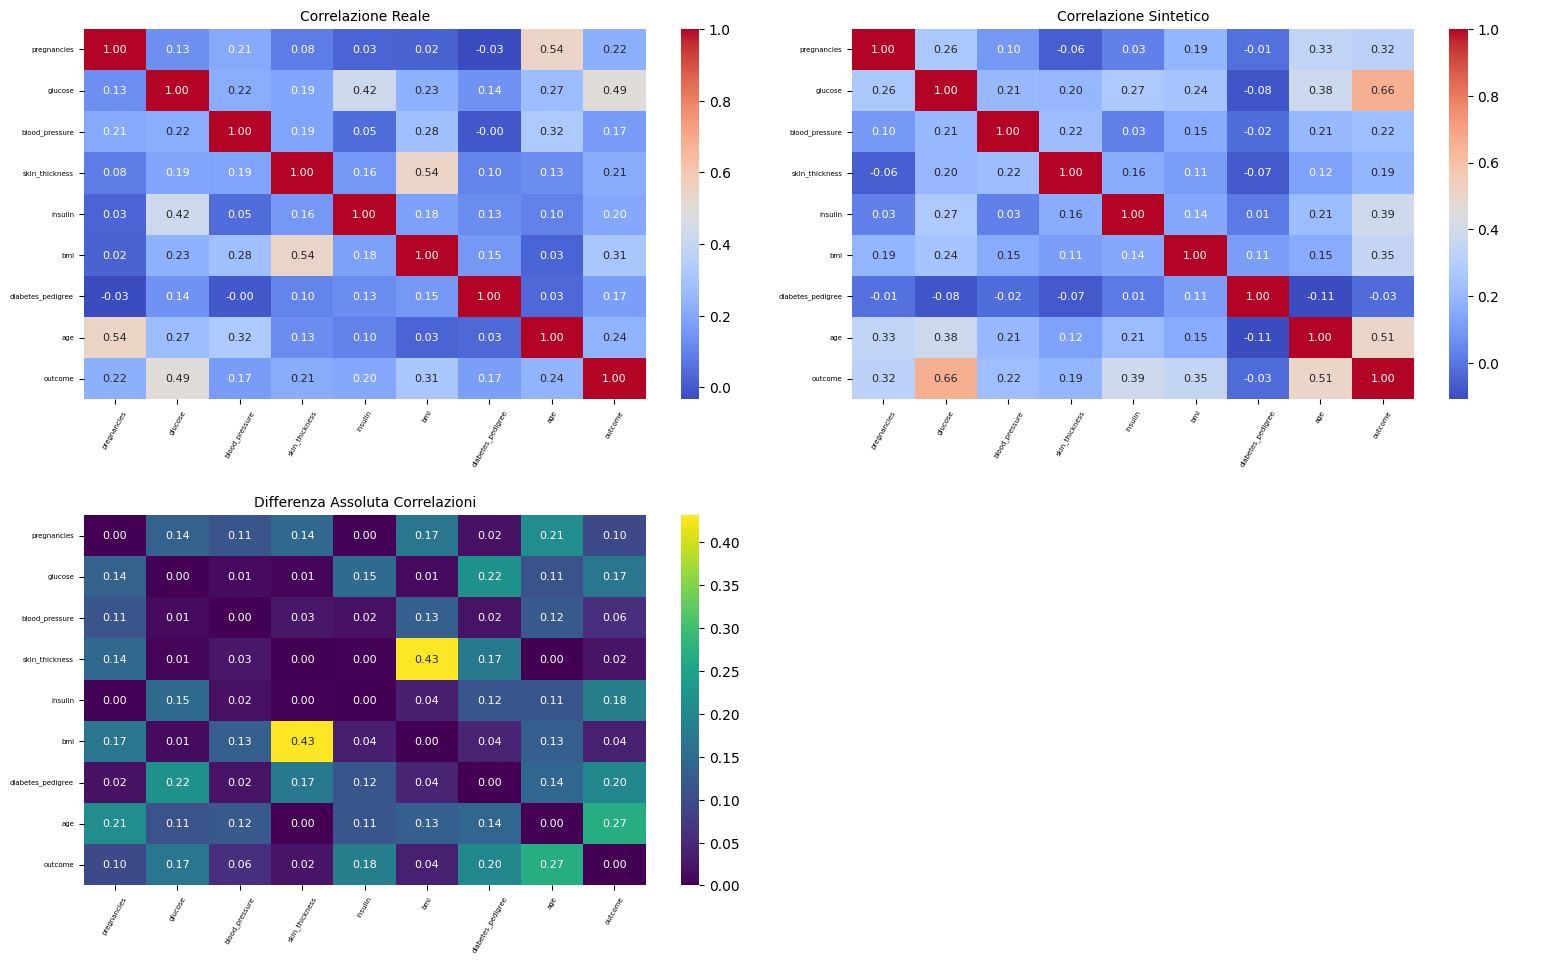

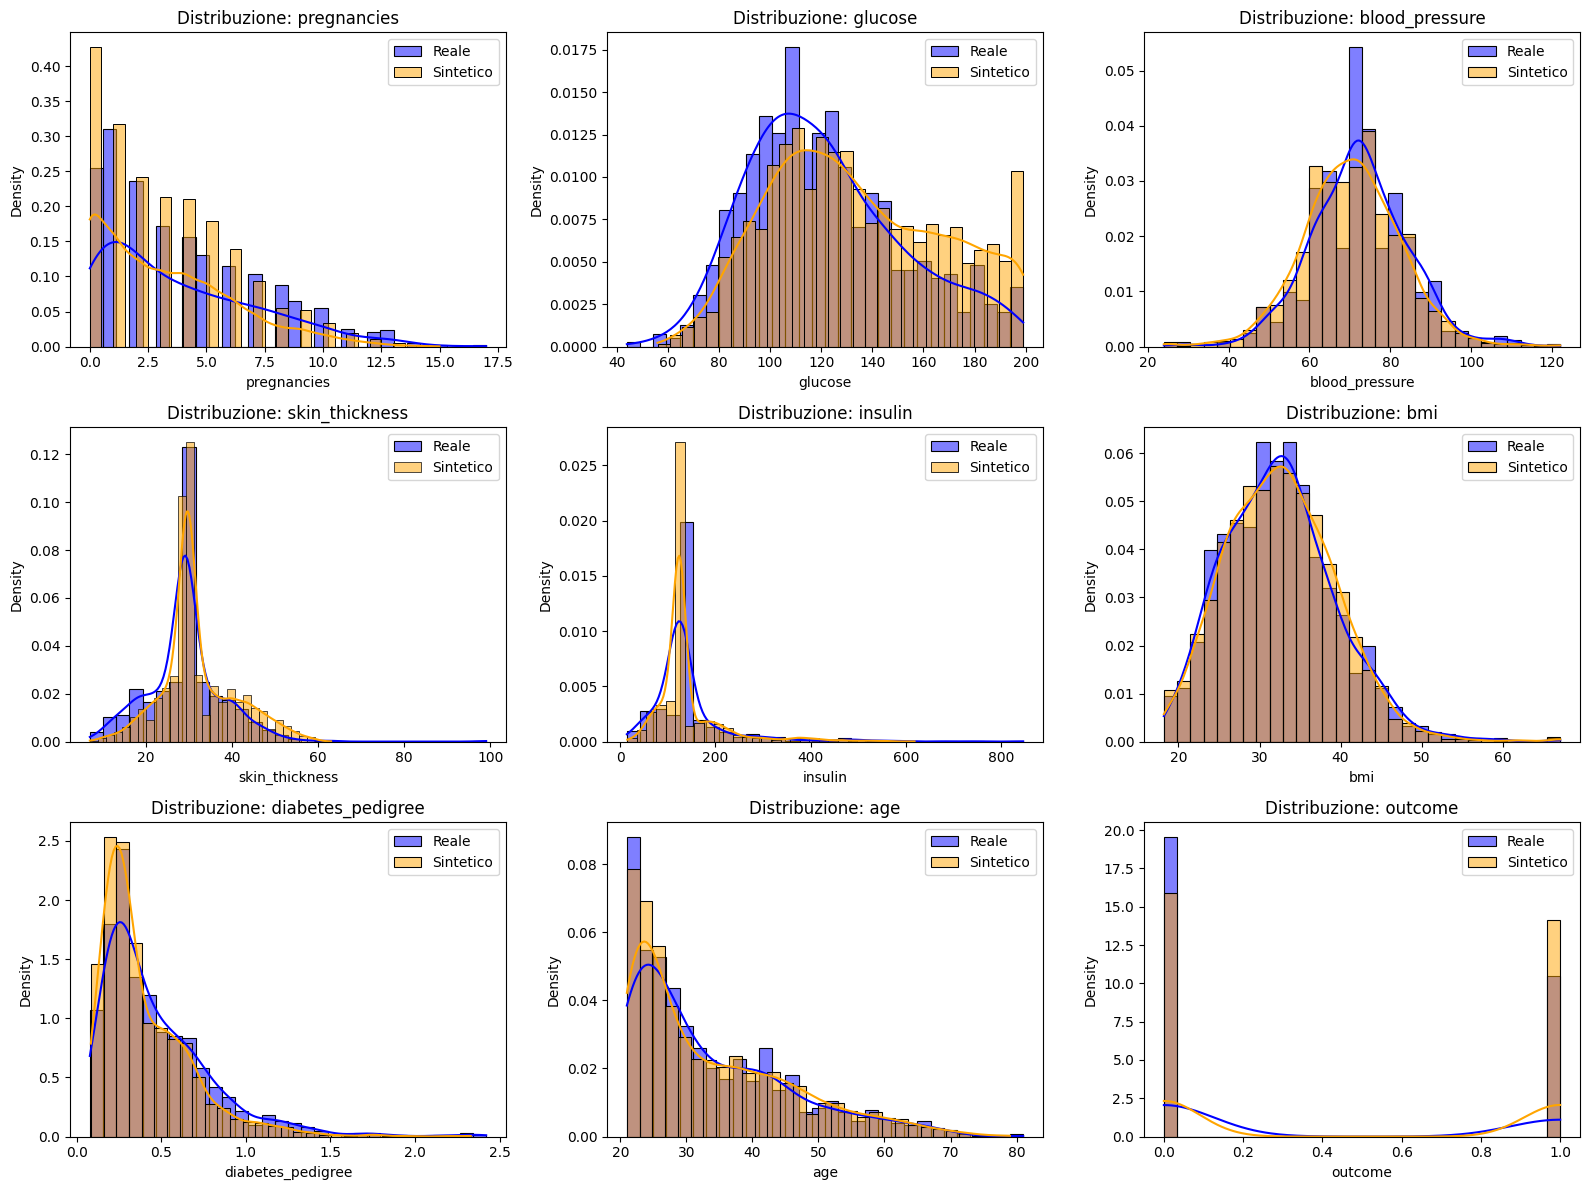


Test statistici standard:

Feature numeriche:
Feature                          KS-p      t-p Levene-p
pregnancies                    0.0002   0.0000   0.0000
glucose                        0.0000   0.0000   0.0000
blood_pressure                 0.0000   0.0000   0.2271
skin_thickness                 0.0000   0.0000   0.3377
insulin                        0.0000   0.7551   0.3649
bmi                            0.4536   0.5669   0.7573
diabetes_pedigree              0.0000   0.0000   0.0000
age                            0.5717   0.2404   0.1285
outcome                        0.0000   0.0000   0.0000

===== ANALISI SOMIGLIANZA STATISTICA: PRIVACY MODERATA =====

Confronto delle medie tra reale e sintetico:
Feature                         Mean Real   Mean Synthetic         Diff
pregnancies                        3.8451           5.2500       1.4049
glucose                          121.6562         126.7564       5.1001
blood_pressure                    72.3867          70.4488      -1.93

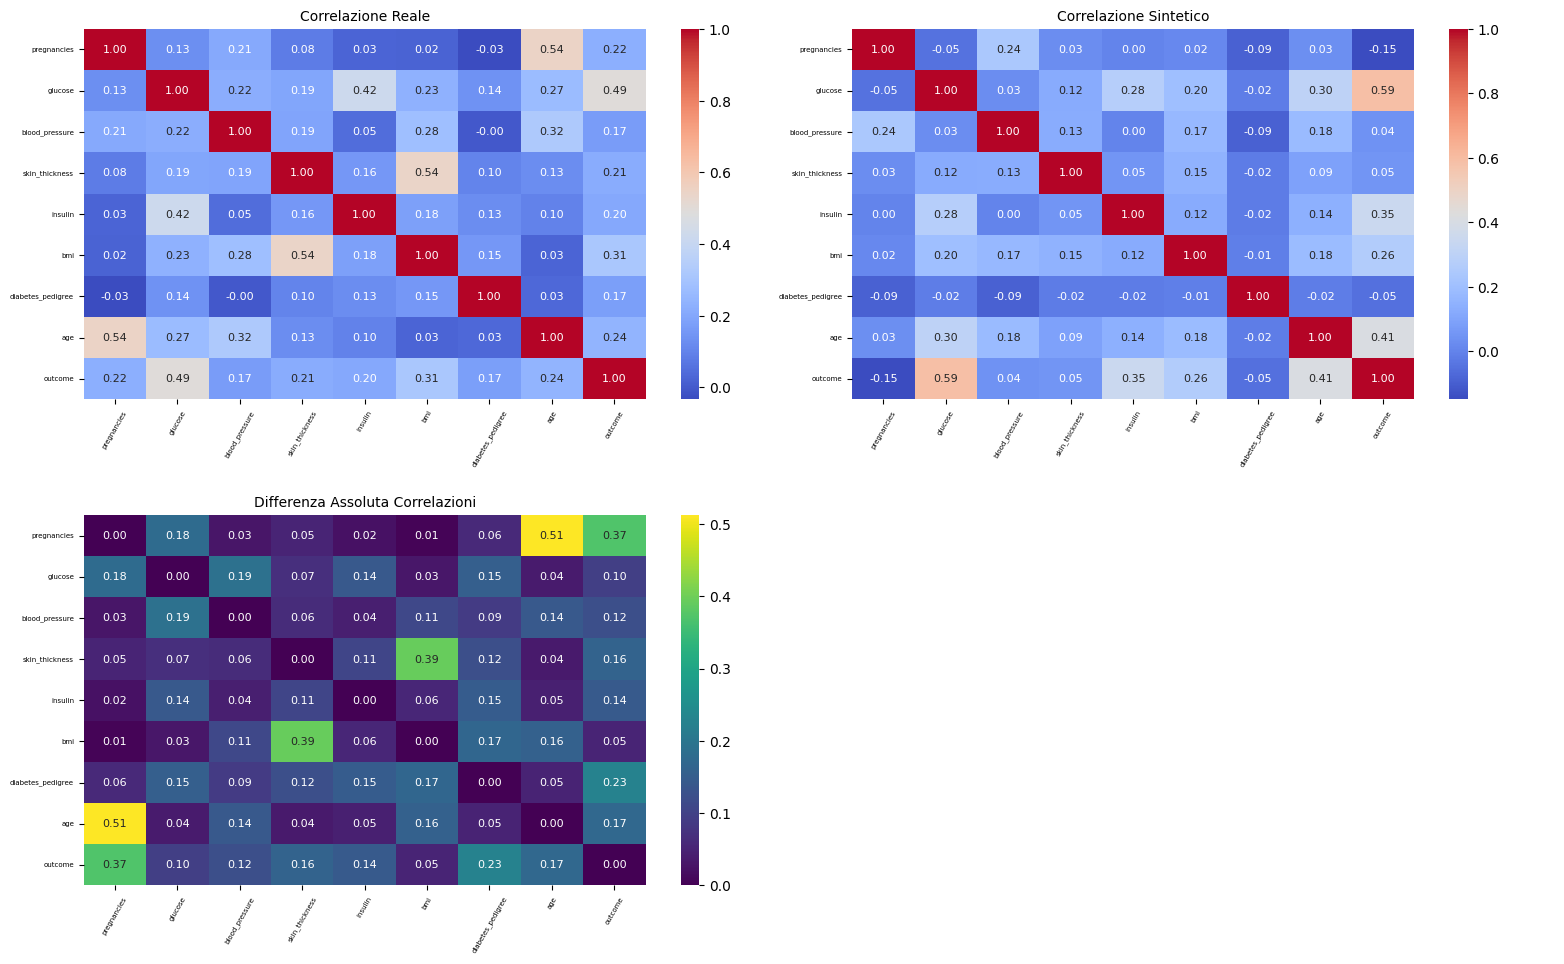

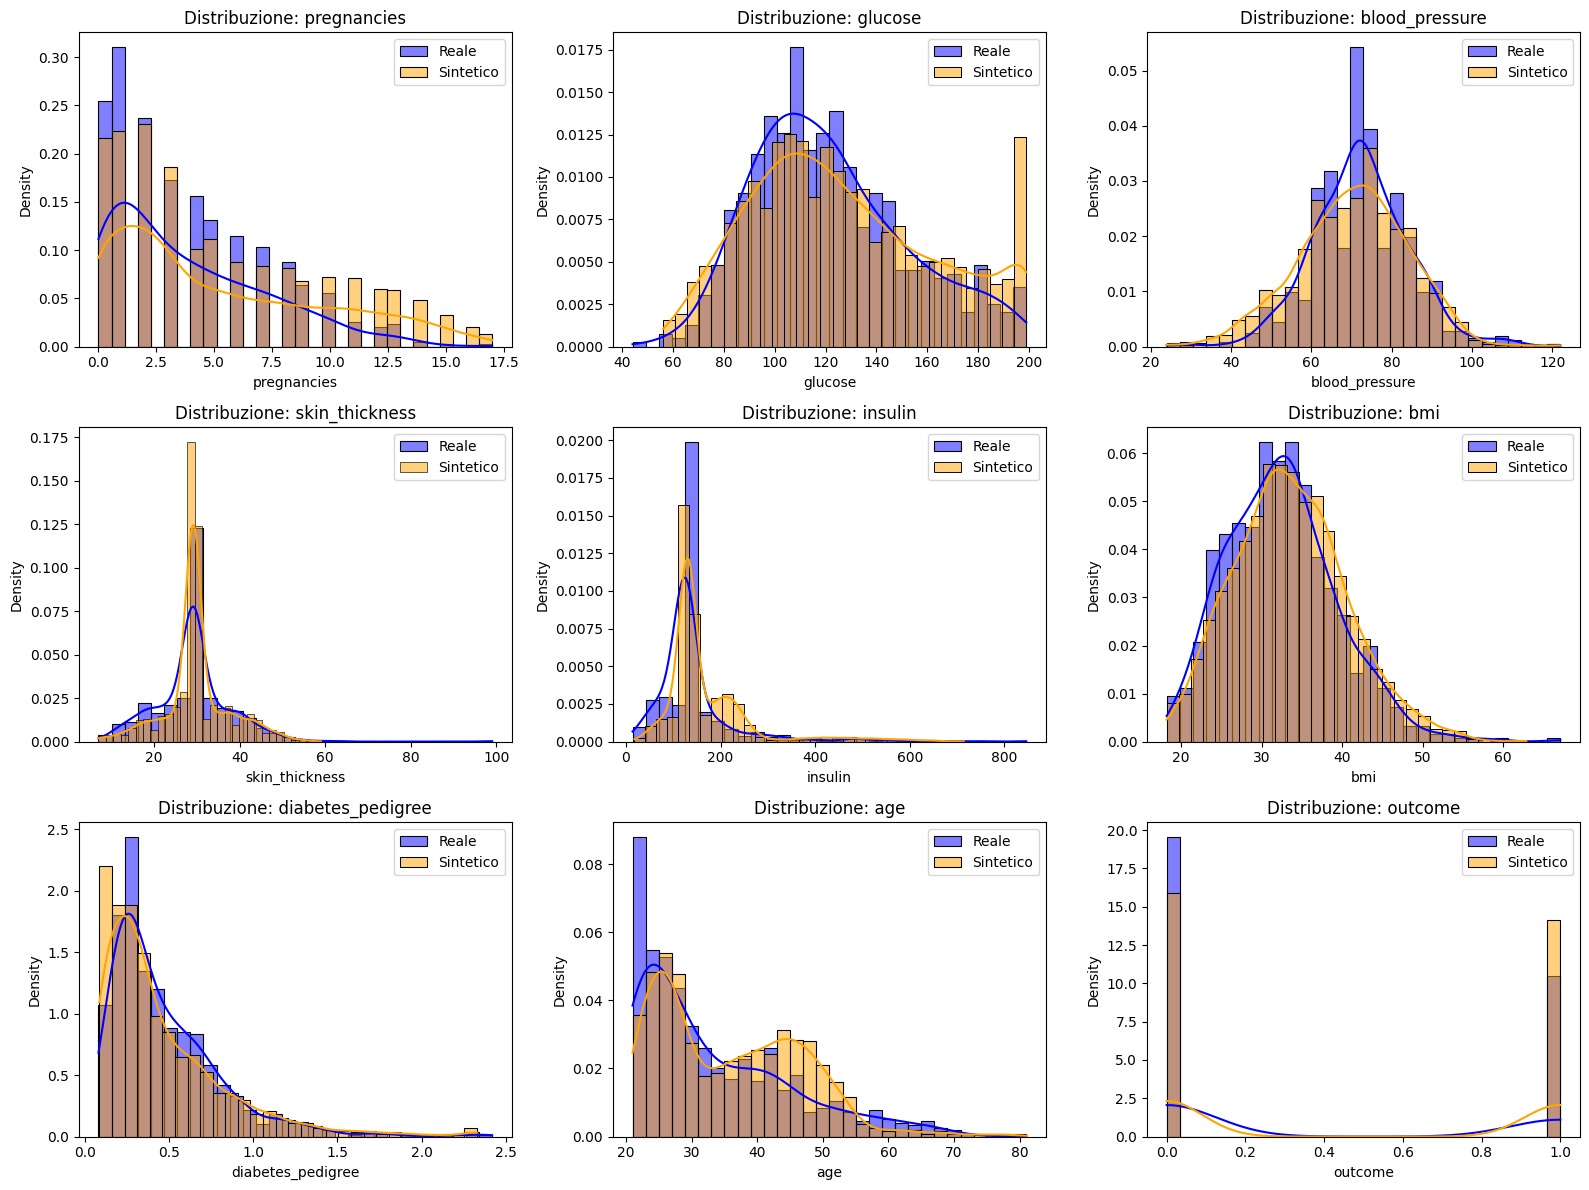


Test statistici standard:

Feature numeriche:
Feature                          KS-p      t-p Levene-p
pregnancies                    0.0000   0.0000   0.0000
glucose                        0.0001   0.0000   0.0000
blood_pressure                 0.0000   0.0001   0.0000
skin_thickness                 0.0000   0.0089   0.0001
insulin                        0.0000   0.0000   0.0002
bmi                            0.0001   0.0000   0.1449
diabetes_pedigree              0.0001   0.5659   0.0238
age                            0.0000   0.0000   0.1784
outcome                        0.0000   0.0000   0.0000

===== ANALISI SOMIGLIANZA STATISTICA: PRIVACY STRONG =====

Confronto delle medie tra reale e sintetico:
Feature                         Mean Real   Mean Synthetic         Diff
pregnancies                        3.8451           6.3516       2.5065
glucose                          121.6562         126.5170       4.8607
blood_pressure                    72.3867          77.0750       4.6883

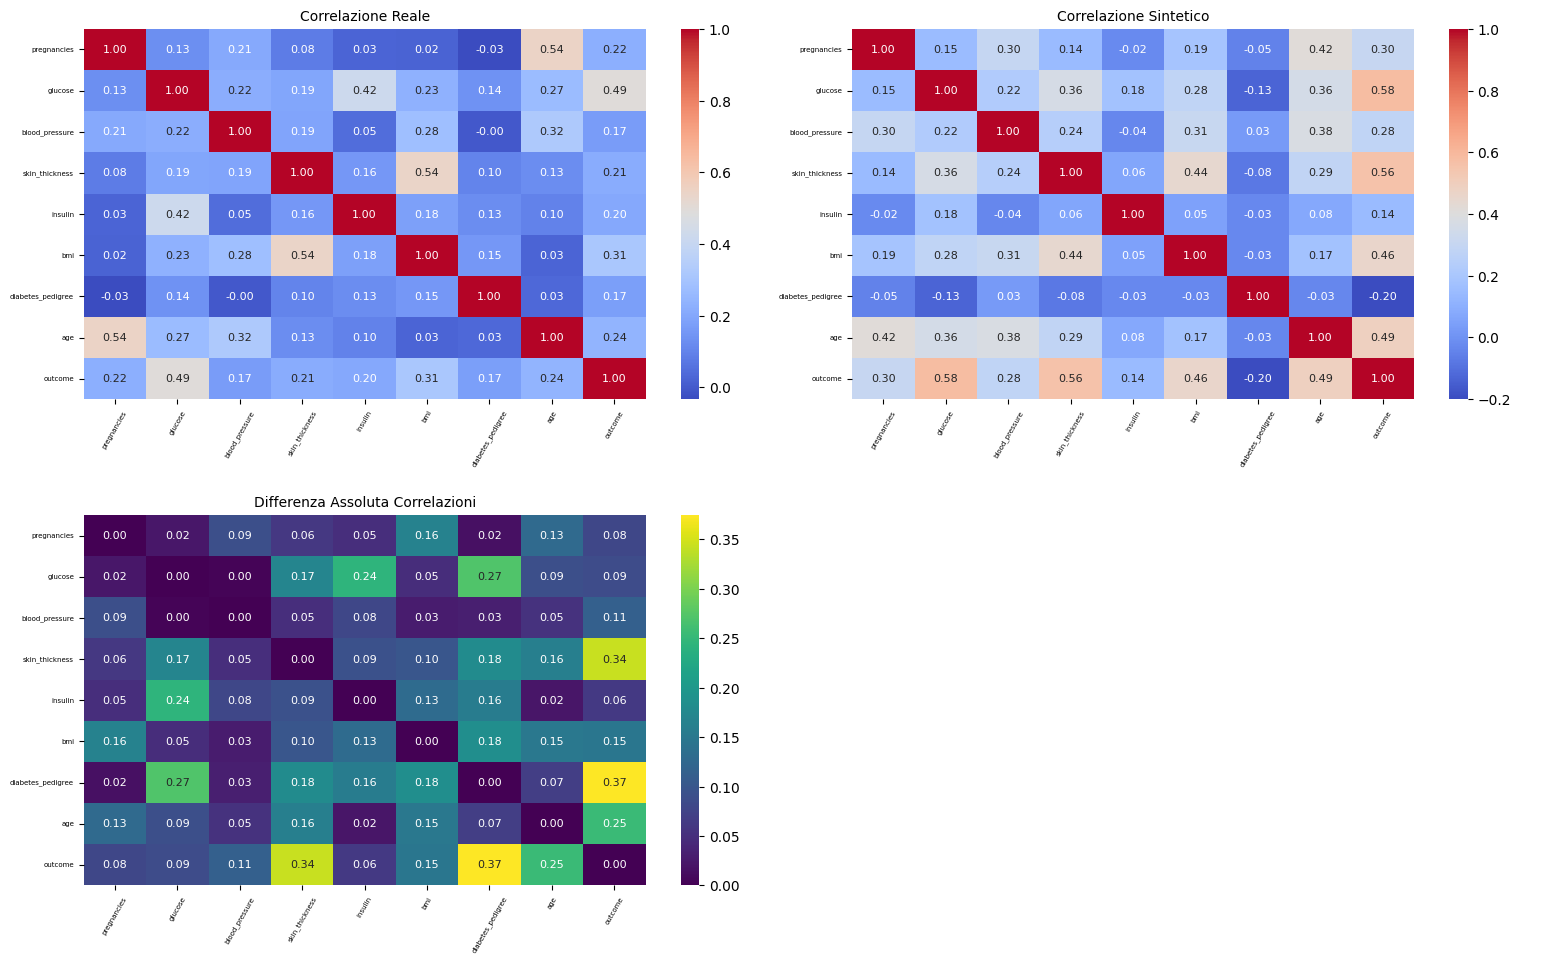

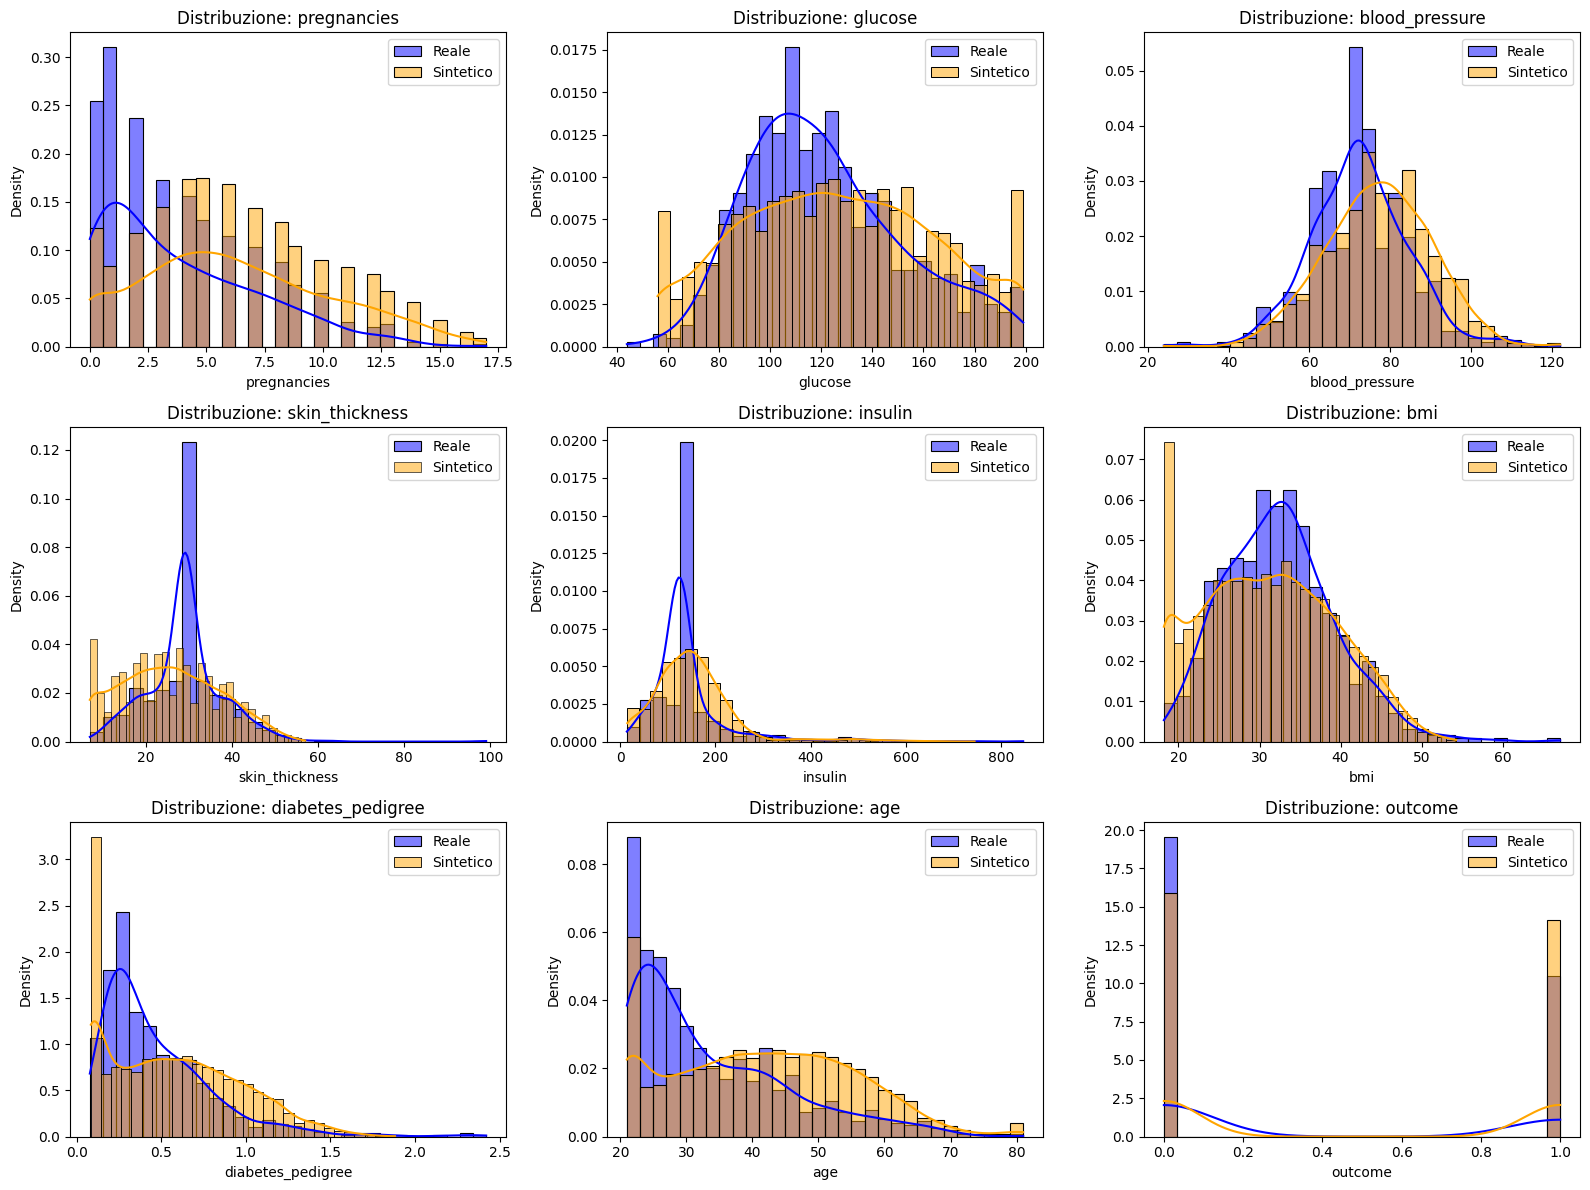


Test statistici standard:

Feature numeriche:
Feature                          KS-p      t-p Levene-p
pregnancies                    0.0000   0.0000   0.0000
glucose                        0.0000   0.0001   0.0000
blood_pressure                 0.0000   0.0000   0.0000
skin_thickness                 0.0000   0.0000   0.0000
insulin                        0.0000   0.0002   0.0000
bmi                            0.0000   0.0000   0.0000
diabetes_pedigree              0.0000   0.0000   0.0000
age                            0.0000   0.0000   0.0000
outcome                        0.0000   0.0000   0.0000


In [129]:
from scipy.stats import ks_2samp, ttest_ind, levene, chi2_contingency

def somiglianza_statistica(real, synth, metadata, nome=""):
    print(f"\n===== ANALISI SOMIGLIANZA STATISTICA: {nome} =====")

    num_cols = [col for col in real.columns if pd.api.types.is_numeric_dtype(real[col])]
    cat_cols = [col for col in real.columns if pd.api.types.is_categorical_dtype(real[col])
                or real[col].nunique() < 20]
    print("\nConfronto delle medie tra reale e sintetico:")
    print("{:<28} {:>12} {:>16} {:>12}".format('Feature', 'Mean Real', 'Mean Synthetic', 'Diff'))
    for col in num_cols:
        mean_real = real[col].mean()
        mean_synth = synth[col].mean()
        diff = mean_synth - mean_real
        print("{:<28} {:>12.4f} {:>16.4f} {:>12.4f}".format(col, mean_real, mean_synth, diff))

    # 2. Confronto MATRICE DI CORRELAZIONE
    print("\nConfronto MATRICE DI CORRELAZIONE:")
    real_corr = real[num_cols].corr()
    synth_corr = synth[num_cols].corr()
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    # Prima riga:
    sns.heatmap(real_corr, ax=axes[0, 0], cmap='coolwarm', annot=True, fmt='.2f', annot_kws={"size":8})
    axes[0, 0].set_title('Correlazione Reale', fontsize=10)
    axes[0, 0].tick_params(axis='x', labelsize=5, rotation=60)
    axes[0, 0].tick_params(axis='y', labelsize=5)
    sns.heatmap(synth_corr, ax=axes[0, 1], cmap='coolwarm', annot=True, fmt='.2f', annot_kws={"size":8})
    axes[0, 1].set_title('Correlazione Sintetico', fontsize=10)
    axes[0, 1].tick_params(axis='x', labelsize=5, rotation=60)
    axes[0, 1].tick_params(axis='y', labelsize=5)
    # Seconda riga:
    axes[1, 1].axis('off')
    sns.heatmap(abs(real_corr - synth_corr), ax=axes[1, 0], cmap='viridis', annot=True, fmt='.2f', annot_kws={"size":8})
    axes[1, 0].set_title('Differenza Assoluta Correlazioni', fontsize=10)
    axes[1, 0].tick_params(axis='x', labelsize=5, rotation=60)
    axes[1, 0].tick_params(axis='y', labelsize=5)
    plt.tight_layout(pad=2)
    plt.show()

    # 3. Confronto DISTRIBUZIONI
    num_per_row = 3
    num_cols_total = len(num_cols)
    num_rows = int(np.ceil(num_cols_total / num_per_row))
    fig_width = 16
    fig_height = 4 * num_rows
    fig, axes = plt.subplots(num_rows, num_per_row, figsize=(fig_width, fig_height))
    axes = axes.flatten()
    for ax, col in zip(axes, num_cols):
        sns.histplot(real[col], color='blue', label='Reale', kde=True, stat="density", bins=30, alpha=0.5, ax=ax)
        sns.histplot(synth[col], color='orange', label='Sintetico', kde=True, stat="density", bins=30, alpha=0.5, ax=ax)
        ax.set_title(f'Distribuzione: {col}')
        ax.set_ylabel('Density')
        ax.set_xlabel(col)
        ax.legend()
    for ax in axes[len(num_cols):]:
        ax.set_visible(False)
    plt.tight_layout()
    plt.show()

    # 4. TEST STATISTICI STANDARD
    print("\nTest statistici standard:")

    # --- Numeriche ---
    print("\nFeature numeriche:")
    print("{:<28} {:>8} {:>8} {:>8}".format('Feature', 'KS-p', 't-p', 'Levene-p'))
    for col in num_cols:
        try:
            ks_p = ks_2samp(real[col], synth[col]).pvalue
            t_p = ttest_ind(real[col], synth[col], equal_var=False).pvalue
            lev_p = levene(real[col], synth[col]).pvalue
            print("{:<28} {:>8.4f} {:>8.4f} {:>8.4f}".format(col, ks_p, t_p, lev_p))
        except Exception as e:
            print(f"{col}: Errore nel calcolo dei test: {e}")

datasets_sintetici = [
    ("NO PRIVACY", synthetic_noprivacy, metadata_noprivacy),
    ("PRIVACY MODERATA", synthetic_mod, metadata_mod),
    ("PRIVACY STRONG", synthetic_strong, metadata_strong)
]

for nome, synth_df, meta in datasets_sintetici:
    somiglianza_statistica(df, synth_df, meta, nome)


### **VALUTARE UTILITA' PER LA RICERCA**: addestrare modelli di predizione delle malattie su dati sintetici e valutarli su un set reale di holdout

**TRINING DEI MODELLI CON I DIVERSI DATASET SINTETICI GENERATI (NO PRIVACY, MODERATA, STRONG)**

In [130]:
def train_and_save_xgboost(synthetic_df, privacy_label, model_params=None, target_col="outcome"):
    """
    Allena un modello XGBoost su un dataset sintetico e lo salva su disco.

    Args:
        synthetic_df: pd.DataFrame, dati sintetici da usare (features + target).
        privacy_label: str, etichetta privacy usata nel nome file ("noprivacy", "mod", "strong").
        model_params: dict, parametri opzionali per XGBClassifier.
        target_col: str, nome della colonna target (default: "outcome").

    Returns:
        Il modello allenato.
    """
    if model_params is None:
        # Parametri di default robusti
        model_params = dict(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.9,
            colsample_bytree=0.9,
            eval_metric="logloss",
            random_state=42
        )
    X = synthetic_df.drop(columns=[target_col])
    y = synthetic_df[target_col]
    model = XGBClassifier(**model_params)
    model.fit(X, y)
    filename = f'xgboost_model_{privacy_label}.pkl'
    joblib.dump(model, filename)
    print(f"Modello XGBoost addestrato e salvato: {filename}")
    return model

# Allena 3 modelli con diversi i dataset sintetici di input
print("Training modello con dataset NO PRIVACY...")
model_noprivacy = train_and_save_xgboost(synthetic_noprivacy, "noprivacy")
print("Training modello con dataset PRIVACY MODERATA...")
model_modprivacy = train_and_save_xgboost(synthetic_mod, "modprivacy")
print("Training modello con dataset PRIVACY STRONG...")
model_strongprivacy = train_and_save_xgboost(synthetic_strong, "strongprivacy")


Training modello con dataset NO PRIVACY...
Modello XGBoost addestrato e salvato: xgboost_model_noprivacy.pkl
Training modello con dataset PRIVACY MODERATA...
Modello XGBoost addestrato e salvato: xgboost_model_modprivacy.pkl
Training modello con dataset PRIVACY STRONG...
Modello XGBoost addestrato e salvato: xgboost_model_strongprivacy.pkl


**TEST DEI MODELLI SU DATI REALI HOLDOUT**

In [132]:
results = []

def test_xgboost_model(model, X_real, y_real, privacy_label):
    y_pred = model.predict(X_real)
    y_prob = model.predict_proba(X_real)[:, 1]

    acc = accuracy_score(y_real, y_pred)
    auc = roc_auc_score(y_real, y_prob)

    print(f"\nPerformance del modello allenato su dati {privacy_label.upper()} e testato su Dataset Reale di Holdout")
    print("Accuracy:", acc)
    print("ROC-AUC:", auc)
    print("\nClassification Report:")
    report = classification_report(y_real, y_pred, output_dict=True)
    print(classification_report(y_real, y_pred))

    # Salva tutte le info
    results.append({
        "privacy_level": privacy_label,
        "accuracy": acc,
        "roc_auc": auc,
        "precision_0": report["0"]["precision"],
        "recall_0": report["0"]["recall"],
        "f1_0": report["0"]["f1-score"],
        "precision_1": report["1"]["precision"],
        "recall_1": report["1"]["recall"],
        "f1_1": report["1"]["f1-score"],
    })


# Separa feature e target nel dataset holdout (lo fai una sola volta)
X_real = holdout_df.drop(columns=["outcome"])
y_real = holdout_df["outcome"]

print("Distribuzione outcome nel test set:")
print(y_real.value_counts(normalize=True))

# Usa la funzione per tutti i modelli
test_xgboost_model(model_noprivacy, X_real, y_real, "no privacy")
test_xgboost_model(model_modprivacy, X_real, y_real, "moderate privacy")
test_xgboost_model(model_strongprivacy, X_real, y_real, "strong privacy")
df_metrics = pd.DataFrame(results)
df_metrics.to_csv("model_performance.csv", index=False)


Distribuzione outcome nel test set:
outcome
0    0.649351
1    0.350649
Name: proportion, dtype: float64

Performance del modello allenato su dati NO PRIVACY e testato su Dataset Reale di Holdout
Accuracy: 0.6623376623376623
ROC-AUC: 0.7581481481481482

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.67      0.72       100
           1       0.51      0.65      0.57        54

    accuracy                           0.66       154
   macro avg       0.65      0.66      0.65       154
weighted avg       0.69      0.66      0.67       154


Performance del modello allenato su dati MODERATE PRIVACY e testato su Dataset Reale di Holdout
Accuracy: 0.6818181818181818
ROC-AUC: 0.75

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.75       100
           1       0.55      0.56      0.55        54

    accuracy                           0.68       154
   macro avg  

### **VALUTARE LA PRIVACY**: implementare Membership Inference Attack per misurare la perdita di informazioni

In [133]:
# =======================Membership Inference Attack =======================
"""
Per ogni generatore sintetico (no-privacy, privacy moderata, privacy strong) costruisce feature che misurano quanto ogni record reale è
ben rappresentato dal sintetico (distanze k-NN, densità locale, errore di ricostruzione), addestra un classificatore XGBoost che
predice se un record appartiene al training set (membro) o al holdout (non-membro) e infine riporta accuratezza e AUC dell’attaccante.
   - Membri = diabetes_train.csv
   - Non-membri = diabetes_holdout
   - Feature MIA: k-NN distance + local density + recon error
   - Attaccante: classificatore supervisionato
"""

import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from xgboost import XGBRegressor, XGBClassifier

# -----------------------------------------------------
# 0. Carica dataset reali e sintetici da CSV
# -----------------------------------------------------
df_real_train   = pd.read_csv("dataset/real/diabetes_train.csv")
df_real_holdout = pd.read_csv("dataset/real/diabetes_holdout.csv")

synthetic_noprivacy = pd.read_csv("dataset/synthetic/synthetic_no_privacy.csv")
synthetic_mod       = pd.read_csv("dataset/synthetic/synthetic_privacy_moderata.csv")
synthetic_strong    = pd.read_csv("dataset/synthetic/synthetic_privacy_strong.csv")

target_col = "outcome"
feature_cols = [c for c in df_real_train.columns if c != target_col]

# ============================================================
# 1. Feature MIA: k-NN distance + local density
# ============================================================
def compute_nn_and_density(real_df, synth_df, feature_cols, k=5, radius=0.5):
    """
    Per ogni record reale calcola:
      - dist_min: distanza al sintetico più vicino
      - dist_mean_k: media delle prime k distanze
      - density_r: numero di sintetici entro un raggio r (normalizzato)
    """
    X_real = real_df[feature_cols].values
    X_synth = synth_df[feature_cols].values

    # Standardizza
    scaler = StandardScaler()
    X_synth_std = scaler.fit_transform(X_synth)
    X_real_std  = scaler.transform(X_real)

    # k-NN distances
    knn = NearestNeighbors(n_neighbors=k, metric="euclidean")
    knn.fit(X_synth_std)
    dists, _ = knn.kneighbors(X_real_std)
    dist_min = dists[:, 0]
    dist_mean_k = dists.mean(axis=1)

    # Local density entro r
    nn_radius = NearestNeighbors(radius=radius, metric="euclidean")
    nn_radius.fit(X_synth_std)
    neigh_idx = nn_radius.radius_neighbors(X_real_std, return_distance=False)
    density_r = np.array([len(idx) for idx in neigh_idx], dtype=float)
    density_r /= (density_r.max() + 1e-8)  # normalizza

    feats = np.vstack([dist_min, dist_mean_k, density_r]).T
    return feats

# ============================================================
# 2. Feature MIA: errore di ricostruzione (model-based)
# ============================================================
def compute_reconstruction_error(real_df, synth_df, feature_cols):
    """
    Serve a misurare quanto un modello addestrato sui dati sintetici riesce a predire le feature dei record reali (errore di ricostruzione medio).
    Se il generatore non rappresenta bene x, l’errore sarà alto.

    Allena un regressore XGBRegressor su sintetico per predire ogni feature
    a partire dalle altre. Per ogni record reale calcola l'errore medio
    di ricostruzione sulle feature.
    """
    X_synth = synth_df[feature_cols].values
    X_real  = real_df[feature_cols].values

    scaler = StandardScaler()
    X_synth_std = scaler.fit_transform(X_synth)
    X_real_std  = scaler.transform(X_real)

    n_features = len(feature_cols)
    errors = np.zeros((X_real_std.shape[0], n_features))

    for j in range(n_features):
        idx_other = [i for i in range(n_features) if i != j]

        X_tr = X_synth_std[:, idx_other]
        y_tr = X_synth_std[:, j]

        model = XGBRegressor(
            n_estimators=150,
            max_depth=3,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=42,
            n_jobs=1
        )
        model.fit(X_tr, y_tr)

        X_te = X_real_std[:, idx_other]
        y_te = X_real_std[:, j]
        y_pred = model.predict(X_te)

        errors[:, j] = (y_te - y_pred) ** 2

    mse_per_record = errors.mean(axis=1)
    return mse_per_record.reshape(-1, 1)  # (n,1)

# ============================================================
# 3. Costruzione dataset MIA
# ============================================================
def build_mia_dataset(real_train, real_holdout, synth_df):
    """
    Costruisce il dataset usato dall’attaccante, con etichette y=1 per membri (records di diabetes_train) e y=0 per non-membri (records di diabetes_holdout).

    Vettore di feature per ciascun record reale x:
      phi(x) = [dist_min, dist_mean_k, density_r, recon_error]
    calcolate rispetto a synth_df.
    """
    # Membri
    feats_nn_train  = compute_nn_and_density(real_train, synth_df, feature_cols,
                                             k=5, radius=0.5)
    feats_rec_train = compute_reconstruction_error(real_train, synth_df, feature_cols)
    X_mem = np.hstack([feats_nn_train, feats_rec_train])
    y_mem = np.ones(len(real_train), dtype=int)

    # Non-membri
    feats_nn_hold  = compute_nn_and_density(real_holdout, synth_df, feature_cols,
                                            k=5, radius=0.5)
    feats_rec_hold = compute_reconstruction_error(real_holdout, synth_df, feature_cols)
    X_non = np.hstack([feats_nn_hold, feats_rec_hold])
    y_non = np.zeros(len(real_holdout), dtype=int)

    X = np.vstack([X_mem, X_non])
    y = np.concatenate([y_mem, y_non])

    return X, y

# ============================================================
# 4. Attaccante supervisionato (XGBoost)
# ============================================================
def run_mia_attack(X, y, test_size=0.3, seed=42):
    """
    Addestrare l’attaccante (classificatore XGBoost) sulle feature MIA e valutare accuracy e AUC.
    """
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=test_size, random_state=seed, stratify=y
    )

    scaler = StandardScaler()
    X_tr_std = scaler.fit_transform(X_tr)
    X_te_std = scaler.transform(X_te)

    attacker = XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="logloss",
        random_state=seed,
        n_jobs=1
    )
    attacker.fit(X_tr_std, y_tr)

    proba = attacker.predict_proba(X_te_std)[:, 1]
    pred = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_te, pred)
    auc = roc_auc_score(y_te, proba)

    return acc, auc

# ============================================================
# 5. Esegui il MIA per ciascun generatore
# ============================================================
results = {}

# CTGAN no‑privacy
X_ctgan, y_ctgan = build_mia_dataset(df_real_train, df_real_holdout, synthetic_noprivacy)
acc_ctgan, auc_ctgan = run_mia_attack(X_ctgan, y_ctgan)
results["CTGAN_no_privacy"] = (acc_ctgan, auc_ctgan)

# DPCTGAN ε=6
X_dp6, y_dp6 = build_mia_dataset(df_real_train, df_real_holdout, synthetic_mod)
acc_dp6, auc_dp6 = run_mia_attack(X_dp6, y_dp6)
results["Privacy moderata"] = (acc_dp6, auc_dp6)

# DPCTGAN ε=2
X_dp2, y_dp2 = build_mia_dataset(df_real_train, df_real_holdout, synthetic_strong)
acc_dp2, auc_dp2 = run_mia_attack(X_dp2, y_dp2)
results["Privacy strong"] = (acc_dp2, auc_dp2)

# ============================================================
# 6. Risultati
# ============================================================
print("\n=== Membership Inference Attack ===")
print(f"{'Generatore':20s} {'ACC':>8s} {'AUC':>8s} {'PrivacyLoss':>14s}")

privacy_results = {}

for name, (acc, auc) in results.items():
    privacy_loss = auc - 0.5          # perdita di info assoluta
    privacy_adv  = 2 * (auc - 0.5)    # vantaggio normalizzato in [0,1]
    privacy_results[name] = {
        "acc": acc,
        "auc": auc,
        "privacy_loss": privacy_loss,
        "privacy_adv": privacy_adv
    }
    print(f"{name:20s} {acc:8.3f} {auc:8.3f} {privacy_loss:14.3f}")

# Trasforma i risultati in DataFrame
df_privacy = pd.DataFrame.from_dict(privacy_results, orient="index")
df_privacy.index.name = "Generatore"

# Salva in CSV
df_privacy.to_csv("mia_results_summary.csv")



=== Membership Inference Attack ===
Generatore                ACC      AUC    PrivacyLoss
CTGAN_no_privacy        0.788    0.582          0.082
Privacy moderata        0.749    0.550          0.050
Privacy strong          0.775    0.447         -0.053


### **VISUALIZZARE IL TRADE-OFF**: tracciare livello di privacy vs. metriche di utilità per identificare il bilanciamento ottimale

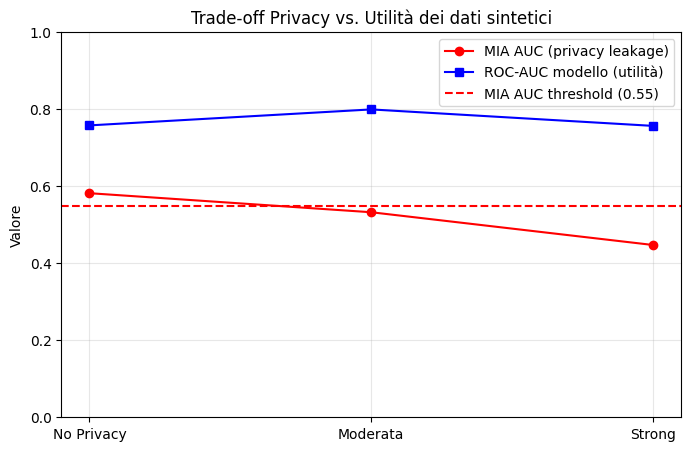

In [125]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica i CSV
mia_df = pd.read_csv("mia_results_summary.csv")
model_df = pd.read_csv("model_performance.csv")

# Ordina livelli di privacy
privacy_levels = ["CTGAN_no_privacy", "Privacy moderata", "Privacy strong"]
x_labels = ["No Privacy", "Moderata", "Strong"]

# Allinea dati
mia_auc = [mia_df[mia_df['Generatore'] == lvl]['auc'].values[0] for lvl in privacy_levels]
model_roc = [
    model_df[model_df['privacy_level'].str.contains("no privacy")]['roc_auc'].values[0],
    model_df[model_df['privacy_level'].str.contains("moderate")]['roc_auc'].values[0],
    model_df[model_df['privacy_level'].str.contains("strong")]['roc_auc'].values[0]
]

# Soglia MIA per considerare privacy non passata
mia_threshold = 0.55

# Crea il grafico
plt.figure(figsize=(8,5))
plt.plot(x_labels, mia_auc, 'o-', color='red', label='MIA AUC (privacy leakage)')
plt.plot(x_labels, model_roc, 's-', color='blue', label='ROC-AUC modello (utilità)')

# Linea tratteggiata soglia MIA
plt.axhline(y=mia_threshold, color='red', linestyle='--', label=f'MIA AUC threshold ({mia_threshold})')

plt.ylim(0,1)
plt.ylabel("Valore")
plt.title("Trade-off Privacy vs. Utilità dei dati sintetici")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [126]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import numpy as np

class EnhancedDiabetesNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.4),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),

            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)
"""
class DiabetesNet(nn.Module):
    def __init__(self, input_dim):
        super(DiabetesNet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.network(x)
"""
# Funzione training rapida (per ciascun dataset sintetico)
def train_model_on_synthetic(synthetic_df, holdout_df, target="outcome", epochs=150):
    feature_cols = [c for c in synthetic_df.columns if c != target]

    # Estrai X/y training e test
    X_train = synthetic_df[feature_cols].values.astype(np.float32)
    y_train = synthetic_df[target].values.astype(np.float32)
    X_test = holdout_df[feature_cols].values.astype(np.float32)
    y_test = holdout_df[target].values.astype(np.float32)

    # Normalizza INPUT (fit sul sintetico)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Dataset e DataLoader
    train_dataset = TensorDataset(torch.tensor(X_train_scaled), torch.tensor(y_train).unsqueeze(1))
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Model + Loss + Ottimizzatore

    # Instanzia e usa una loss, optimizer con weight decay
    model = EnhancedDiabetesNet(input_dim=len(feature_cols))
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)

    """
    model = DiabetesNet(input_dim=len(feature_cols))
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0015, weight_decay=1e-4)
    """
    # Addestramento semplice senza early stopping (puoi aggiungerlo se vuoi)
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        if (epoch+1) % 30 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss/len(train_loader):.4f}")

    # Valutazione sul test reale Holdout
    model.eval()
    with torch.no_grad():
        y_pred_prob = model(torch.tensor(X_test_scaled)).squeeze().numpy()
        y_pred = (y_pred_prob > 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    report = classification_report(y_test, y_pred)

    return model, acc, auc, report

# --- TRAIN and TEST su 3 dataset sintetici ---

print("=== TRAIN su synthetic_no_privacy ===")
model_noprivacy, acc_noprivacy, auc_noprivacy, report_noprivacy = train_model_on_synthetic(synthetic_noprivacy, holdout_df)

print("\n=== TRAIN su synthetic_privacy_moderata ===")
model_mod, acc_mod, auc_mod, report_mod = train_model_on_synthetic(synthetic_mod, holdout_df)

print("\n=== TRAIN su synthetic_privacy_strong ===")
model_strong, acc_strong, auc_strong, report_strong = train_model_on_synthetic(synthetic_strong, holdout_df)

# Stampa risultati finali
print("\n=== RISULTATI SU HOLDOUT REALE ===")
print(f"NO PRIVACY:    Accuracy={acc_noprivacy:.4f}, ROC AUC={auc_noprivacy:.4f}")
print(report_noprivacy)

print(f"\nPRIVACY MODERATA: Accuracy={acc_mod:.4f}, ROC AUC={auc_mod:.4f}")
print(report_mod)

print(f"\nPRIVACY STRONG: Accuracy={acc_strong:.4f}, ROC AUC={auc_strong:.4f}")
print(report_strong)


=== TRAIN su synthetic_no_privacy ===
Epoch 30/150 - Loss: 0.2601
Epoch 60/150 - Loss: 0.2540
Epoch 90/150 - Loss: 0.2359
Epoch 120/150 - Loss: 0.2359
Epoch 150/150 - Loss: 0.2351

=== TRAIN su synthetic_privacy_moderata ===
Epoch 30/150 - Loss: 0.4048
Epoch 60/150 - Loss: 0.3946
Epoch 90/150 - Loss: 0.3872
Epoch 120/150 - Loss: 0.3864
Epoch 150/150 - Loss: 0.3799

=== TRAIN su synthetic_privacy_strong ===
Epoch 30/150 - Loss: 0.3020
Epoch 60/150 - Loss: 0.2920
Epoch 90/150 - Loss: 0.2954
Epoch 120/150 - Loss: 0.2790
Epoch 150/150 - Loss: 0.2834

=== RISULTATI SU HOLDOUT REALE ===
NO PRIVACY:    Accuracy=0.6623, ROC AUC=0.7446
              precision    recall  f1-score   support

         0.0       0.77      0.68      0.72       100
         1.0       0.52      0.63      0.57        54

    accuracy                           0.66       154
   macro avg       0.64      0.65      0.65       154
weighted avg       0.68      0.66      0.67       154


PRIVACY MODERATA: Accuracy=0.7013, RO